# ATTENTION IN MACHINE LEARNING TRANSLATION
## Dịch các câu từ tiếng Anh sang tiếng Việt với cơ chế Attention

Trong bài tập trước, chúng ta đã làm quen và thực hành bài tập Dịch máy từ ngôn ngữ tiếng Anh sang tiếng Việt với sự hỗ trợ của mô hình Seq2Seq. Tuy nhiên, dễ thấy rằng, kết quả đánh giá hiệu năng thu được còn hạn chế.

Vậy, làm thế nào để cải thiện khả năng dịch thuật của mô hình Dịch máy?

<table>
<tr>
  <td>
   <img width=700 src="https://scontent.fsgn15-1.fna.fbcdn.net/v/t1.15752-9/335033530_123515087186693_2765806321722102319_n.png?_nc_cat=101&ccb=1-7&_nc_sid=ae9488&_nc_ohc=PmEE_PLZpYkAX-IiFiD&_nc_ht=scontent.fsgn15-1.fna&oh=03_AdTVSDAsOGxadp53fC0InRxLLhVJm5KVTfOjHYxRZjlVmA&oe=642F94B9"/>
  </td>
</tr>
<tr>
  <th colspan=1>Minh họa sử dụng cơ chế Attention cho Encoder/Decoder.</th>
<tr>
</table>

Cơ chế Attention là một trong những giải pháp tiềm năng để giải quyết vấn đề này thông qua quá trình tập trung vào các vùng thông tin quan trọng để giúp mô hình học tốt hơn. Với cơ chế Attention, một "từ" có thể hiệu chỉnh được trọng số của nó cho các từ khác trong câu, sao cho các từ ở gần nó thì trọng số lớn hơn, ở xa nó thì trọng số nhỏ hơn. 

Mỗi "câu" sau khi đi qua bước embedding sẽ được biểu diễn dưới dạng một ma trận X(m, n) với m, n lần lượt thể hiện số từ và số chiều của mỗi vector từ được biểu diễn. Mô hình sẽ cần học được bộ trọng số (Wq, Wk, Wv) để thu được ma trận Q, K, V (Query, Key và Value). Ma trận Query và Key có tác dụng tính toán ra score cho các cặp từ. Ma trận Value sẽ dựa trên score để tính ra vector phân phối xác suất đầu ra. Hàm softmax được sử dụng để đưa giá trị score về một phân phối xác suất mà độ lớn sẽ đại diện cho mức độ attention của từ query và từ key. Như vậy mỗi một từ sẽ được biểu diễn bởi 3 vector Query, Key và Value. Bộ ba này sẽ thể hiện trọng số của mỗi từ với các từ còn lại trong câu. (Xem hình minh họa)

<table>
<tr>
  <td>
   <img width=700 src="https://scontent.fsgn15-1.fna.fbcdn.net/v/t1.15752-9/335035086_1199463037552521_2920042504129337261_n.png?_nc_cat=107&ccb=1-7&_nc_sid=ae9488&_nc_ohc=MqlheVZ5DkcAX85qd-4&_nc_ht=scontent.fsgn15-1.fna&oh=03_AdRIMpW_IFpdIgXQjTADD9IbqM97fsM8EdJ3S7pKn1STYw&oe=642F6FDE"/>
  </td>
</tr>
<tr>
  <th colspan=1>Minh họa kết quả tính toán attention cho từng từ trong câu. (Blog phamdinhkhanh)</th>
<tr>
</table>

Trong bài tập này, chúng ta sẽ tạo ra một mô hình LSTM encoder-decoder sử dụng [Keras Functional API](https://www.tensorflow.org/alpha/guide/keras/functional ( với [TensorFlow](https://www.tensorflow.org/) ). Sau đó, chúng ta thực hành chuyển đổi các câu tiếng Anh sang Tiếng Việt như bài tập lần trước. Sự khác biệt ở đây chính là chúng ta sẽ cài đặt thêm một Attention Head để cải thiện hiệu năng.

Lưu ý: Sử dụng GPU để có thể huấn luyện mô hình nhanh hơn.

Chúng ta cùng thực hiện các bước khởi tạo mô hình như bài tập lần trước nhé!

## Chuẩn bị dữ liệu

### 1) Khai báo các thư viện

Chúng ta sẽ khai báo TensorFlow và Keras. Từ Keras, chúng ta sẽ sử dụng các module khác để giúp xây dựng các lớp NN, tiền xử lý dữ liệu và xây dựng các mô hình LSTM

In [1]:
# import các thư viện cần thiết
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers , activations , models , preprocessing , utils
import pandas as pd
from keras.models import load_model, Model
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def fix_random_seed():
    np.random.seed(1)
    tf.random.set_seed(1)

### 2) Đọc dữ liệu


Dữ liệu có hơn 9K cặp cụm từ English-Vietnamese. Bộ dữ liệu này có thể tải tại http://www.manythings.org/anki/. Hơn thế nữa, tại đây có hơn 50 bộ câu song ngữ. Chúng ta sẽ tải bộ dữ liệu cụm từ English-Vietnamese, giải nén và đọc bằng [Pandas](https://pandas.pydata.org/).

**Server đã có sẵn dữ liệu này cho các bạn sử dụng, các bạn có thể sử dụng các lệnh dưới đây để tải và sử dụng dữ liệu trên các nền tảng khác.**

In [52]:
# !wget http://www.manythings.org/anki/vie-eng.zip -O vie-eng.zip
# !unzip vie-eng.zip

Sử dụng pandas để đọc dữ liệu và thêm tên cho các cột.

In [53]:
lines = None

# TODO: đọc dữ liệu bằng `padas.read_table`, 
# gắn label cho 2 cột đầu là `eng` và `vie`,
# loại bỏ cột cuối cùng

# BEGIN SOLUTION
lines = pd.read_table('/data/cs2230/vie.txt' , names=['eng' , 'vie' , 'c' ] )
lines = lines.drop( 'c' , 1 )
# END SOLUTION

lines.head()

/tmp/ipykernel_28141/2228967803.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  lines = lines.drop( 'c' , 1 )


,eng,vie
0,Run!,Chạy!
1,Run!,Chạy đi!
2,Help!,Giúp tôi với!
3,Help!,Cứu tôi!
4,Jump!,Nhảy đi!


In [4]:
# Kiểm tra với bộ test
assert str(type(lines)) =="<class 'pandas.core.frame.DataFrame'>" 
assert list(lines.columns) == ['eng' , 'vie']
assert lines.shape == (9144, 2) 
assert lines.iloc[10]['eng']=='Hurry!'
print('Bạn đã qua bài test')

Bạn đã qua bài test


In [5]:
# Kiểm tra với bộ test ẩn
# BEGIN HIDDEN TESTS
assert str(type(lines)) =="<class 'pandas.core.frame.DataFrame'>" 
assert list(lines.columns) == ['eng' , 'vie']
assert lines.shape == (9144, 2) 
assert lines.iloc[10]['eng']=='Hurry!'
index = [150, 200, 500]
gt = ["I don't know.", 'Trust no one.', 'This car is his.']
for i, gt in zip(index, gt):
    assert lines.iloc[i]['eng']==gt
# END HIDDEN TESTS

### 3) Chuẩn bị dữ liệu đầu vào cho Encoder (`encoder_input_data`)
Mô hình Encoder sẽ được cung cấp dữ liệu đầu vào là các câu tiếng Anh đã được tiền xử lý. 
Bước tiền xử lý được thực hiện như sau:

Token hóa các câu tiếng Anh từ `eng_lines`.
Xác định độ dài tối đa của câu tiếng Anh là `max_input_length`.
Thêm vào `tokenized_eng_lines` để đạt đến `max_input_length`.
Xác định kích thước từ vựng (`num_eng_tokens`) cho các từ tiếng Anh.

In [6]:
eng_lines = list()
for line in lines.eng:
    eng_lines.append( line ) 

tokenizer = None
tokenized_eng_lines = None
max_input_length =  None

# TODO: Sử dụng `preprocessing.text.Tokenizer` để biến đổi các câu thành các 
# tokens và lưu vào biến `tokenized_eng_lines`. Biến `max_input_length` lưu trữ
# độ dài tối đa của các tokens.
# Gợi ý: dùng 2 hàm là `fit_on_texts` và `texts_to_sequences`

# BEGIN SOLUTION
eng_tokenizer = preprocessing.text.Tokenizer()
eng_tokenizer.fit_on_texts( eng_lines ) 
tokenized_eng_lines = eng_tokenizer.texts_to_sequences( eng_lines ) 
max_input_length = np.array( [len( token_seq ) for token_seq in tokenized_eng_lines] ).max()
# END SOLUTION

# sử dụng pad_sequences để cố định kích thước input của encoder
padded_eng_lines = preprocessing.sequence.pad_sequences( tokenized_eng_lines, maxlen=max_input_length , padding='post' )
encoder_input_data = np.array( padded_eng_lines )

eng_word_dict = eng_tokenizer.word_index
num_eng_tokens = len( eng_word_dict )+1

print( 'Độ dài lớn nhất của English là {}'.format( max_input_length ))
print( 'Kích thước dữ liệu của Encoder  -> {}'.format( encoder_input_data.shape ))
print( 'Số lượng English tokens = {}'.format( num_eng_tokens))

Độ dài lớn nhất của English là 32
Kích thước dữ liệu của Encoder  -> (9144, 32)
Số lượng English tokens = 4054


### 4) Chuẩn bị dữ liệu đầu vào cho Decoder ( `decoder_input_data` )
Mô hình decoder sẽ được cung cấp dữ liệu tiếng Việt đã được tiền xử lý. Các bước tiền xử lý giống như trên. Bước này được thực hiện trước các bước khác.

Thêm nhãn `<START>` vào vị trí đầu tiên trong mỗi câu tiếng Việt.
Thêm nhãn `<END>` vào vị trí cuối cùng trong mỗi câu tiếng Việt.



In [7]:
vie_lines = list()
# TODO: Khác với trên chúng ta phải thêm '<START> ' và ' <END>' vào 
# các câu tiếng Việt để tạo thành các dữ liệu đầu vào cho decoder

# BEGIN SOLUTION
for line in lines.vie:
    vie_lines.append( '<START> ' + line + ' <END>' )  
# END SOLUTION

tokenizer = None
tokenized_vie_lines = None
max_output_length = None

# TODO: Tương tự như trên, chúng ta cũng sử dụng `preprocessing.text.Tokenizer` 
# để biến đổi các câu thành các tokens và lưu vào biến `tokenized_vie_lines`. 
# Biến `max_output_length` lưu trữ độ dài tối đa của các tokens.
# Gợi ý: dùng 2 hàm là `fit_on_texts` và `texts_to_sequences`

# BEGIN SOLUTION
vie_tokenizer = preprocessing.text.Tokenizer()
vie_tokenizer.fit_on_texts( vie_lines ) 
tokenized_vie_lines = vie_tokenizer.texts_to_sequences( vie_lines ) 
max_output_length = np.array( [len( token_seq ) for token_seq in tokenized_vie_lines] ).max()
# END SOLUTION

# sử dụng pad_sequences để cố định kích thước output của decoder
padded_vie_lines = preprocessing.sequence.pad_sequences( tokenized_vie_lines , maxlen=max_output_length, padding='post' )
decoder_input_data = np.array( padded_vie_lines )
vie_word_dict = vie_tokenizer.word_index
num_vie_tokens = len( vie_word_dict )+1


print( 'Độ dài lớn nhất của tiếng việt là {}'.format( max_output_length ))
print( 'kích thước dữ liệu đầu vào của Decoder -> {}'.format( decoder_input_data.shape ))
print( 'Số lượng Vietnamese tokens = {}'.format( num_vie_tokens))

Độ dài lớn nhất của tiếng việt là 43
kích thước dữ liệu đầu vào của Decoder -> (9144, 43)
Số lượng Vietnamese tokens = 2478


In [8]:
# Kiểm tra với bộ test
assert num_eng_tokens == 4054
assert num_vie_tokens == 2478
assert decoder_input_data.shape == (9144, 43)
assert encoder_input_data.shape == (9144, 32)
assert tokenized_vie_lines[50:55] == [[1, 378, 2],
 [1, 11, 9, 14, 21, 3, 2],
 [1, 11, 9, 14, 21, 22, 2],
 [1, 1212, 57, 2],
 [1, 1212, 57, 18, 2]]
assert tokenized_eng_lines[50:55] == [[52, 294], [52, 1462], 
                                      [52, 1462], [180, 137], [180, 137]]
print('Bạn đã qua bài test')                                      

Bạn đã qua bài test


In [9]:
# Kiểm tra với bộ test ẩn
# BEGIN HIDDEN TESTS
assert num_eng_tokens == 4054
assert num_vie_tokens == 2478
assert decoder_input_data.shape == (9144, 43)
assert encoder_input_data.shape == (9144, 32)

assert tokenized_vie_lines[50:55] == [[1, 378, 2],
 [1, 11, 9, 14, 21, 3, 2],
 [1, 11, 9, 14, 21, 22, 2],
 [1, 1212, 57, 2],
 [1, 1212, 57, 18, 2]]
assert tokenized_eng_lines[50:55] == [[52, 294], [52, 1462], 
                                      [52, 1462], [180, 137], [180, 137]]
assert tokenized_vie_lines[10:20] == [[1, 271, 130, 2],
 [1, 271, 130, 39, 2],
 [1, 3, 16, 245, 2],
 [1, 3, 16, 245, 143, 69, 2],
 [1, 1840, 2],
 [1, 55, 18, 2],
 [1, 55, 42, 18, 2],
 [1, 157, 65, 2],
 [1, 113, 30, 2],
 [1, 96, 69, 2]]

assert tokenized_eng_lines[80:90] == [[138, 13, 163],
 [57, 948],
 [50, 7, 59],
 [50, 7, 59],
 [50, 7, 59],
 [4, 1817],
 [4, 1817],
 [432, 48],
 [26, 2500],
 [17, 866]]

assert tokenized_eng_lines[99:102] == [[1, 31, 1215], 
                                       [1, 31, 1818], 
                                       [1, 165, 48]]
# END HIDDEN TESTS

### 5) Chuẩn bị nhãn cho decoder ( decoder_target_data )

Chúng ta sẽ lấy một bản sao của `tokenized_vie_lines` và sửa đổi nó như sau:

1. Chúng ta sẽ xóa nhãn `<start>` mà chúng ta đã đính kèm trước đó. Vì vậy, từ `<start>` sẽ bị xóa.

2. Chuyển đổi `padded_vie_lines` (những dòng không có nhãn `<start>`) sang các vector one-hot để huấn luyện mô hình.
Ví dụ:

```
 [ '<start>' , 'hello' , 'world' , '<end>' ]

```

sẽ trở thành

```
 [ 'hello' , 'world' , '<end>' ]

```



In [10]:
input_decoder_target_data = list()

# TODO: chúng ta sẽ loại bỏ '<START> ' đầu tiên của các dòng trong biến `tokenized_vie_lines`
# và thêm vào `input_decoder_target_data`

# BEGIN SOLUTION
for token_seq in tokenized_vie_lines:
    input_decoder_target_data.append( token_seq[ 1 : ] ) 
# END SOLUTION

padded_vie_lines = preprocessing.sequence.pad_sequences(input_decoder_target_data , maxlen=max_output_length, padding='post' )
onehot_vie_lines = utils.to_categorical( padded_vie_lines , num_vie_tokens )
decoder_target_data = np.array( onehot_vie_lines )
print( 'Decoder target data shape -> {}'.format( decoder_target_data.shape))

Decoder target data shape -> (9144, 43, 2478)


In [11]:
# Kiểm tra với bộ test
assert decoder_target_data.shape==(9144, 43, 2478)
# test remove start in decode_data
for i in [5, 10, 15, 20]:
    assert (sum(tokenized_vie_lines[i]) - sum(input_decoder_target_data[i])) == 1
print('Bạn đã qua bài test')    

Bạn đã qua bài test


In [12]:
# BEGIN HIDDEN TESTS
# Kiểm tra với bộ test ẩn
assert decoder_target_data.shape==(9144, 43, 2478)
assert (padded_vie_lines[50:52]==np.array([ \
    [378, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [11, 9, 14, 21, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],)).all() == True
# test remove start in decode_data
for i in range(lines.shape[0]):
    assert (sum(tokenized_vie_lines[i]) - sum(input_decoder_target_data[i])) == 1
# END HIDDEN TESTS

## Định nghĩa và huấn luyện các mô hình

### 1) Định nghĩa mô hình Encoder-Decoder

Giống như bài trước, mô hình sẽ có các lớp Embedding, LSTM và Dense. Tuy nhiên,decoder sẽ có thêm lớp attention, cấu hình cơ bản như sau:

* 2 lớp đầu vào: Một cho `encoder_input_data` và một cho `decoder_input_data`.
* Lớp Embedding: Để chuyển đổi các vector token sang các dense có kích thước cố định = 256. ***(Lưu ý: để tham số `mask_zero=True`, `return_state=True`, `return_sequences=True`)***
* Lớp LSTM: khởi tạo layer chứa 128 Long-Short Term cell.
Hoạt động:

1. `encoder_input_data` đầu vào lớp Embedding (`encoder_embedding`).
2. Kết quả của lớp Embedding đi đến layer LSTM để tạo ra 2 vector trạng thái (`h` và `c` là `encoder_states`)
3. Những trạng thái này được đưa vào trong layer LSTM của decoder.
4. decoder_input_data đầu vào qua lớp Embedding.
5. Embeddings đi vào lớp LSTM (mà có các trạng thái) để tạo các chuỗi.
6. Các đầu ra của lớp LSTM sẽ đi qua lớp `AttentionLayer` do chúng ta định nghĩa trước khi vào lớp cuối cùng `Dense`.




Khác với bài trước chúng ta sẽ định nghĩa các module như encoder, decoder và attention từ lớp `tf.keras.layers.Layer` và sẽ thiết kế lớp Translator để kết hợp encoder và decoder.

In [13]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_eng_tokens, units=[256, 128]):
        super(Encoder, self).__init__()

        self.embedding = tf.keras.layers.Embedding(num_eng_tokens, units[0], mask_zero=True)
        self.lstm = tf.keras.layers.LSTM(units[1], return_state=True, return_sequences=True)

    def call(self, x):

        # TODO: `x` sẽ được đi qua lớp 'self.embedding' và `self.lstm` đã tạo ra states và output.

        # BEGIN SOLUTION
        x = self.embedding(x)
        x, state_h , state_c = self.lstm(x)
        # END SOLUTION

        return x, [state_h , state_c]


In [14]:
# Chúng ta sẽ kiểm tra thử input và output của encoder thông qua đoạn code dưới
x = tf.random.uniform(shape=[8, 16]) # random sample

encoder = Encoder(num_eng_tokens)
context, state = encoder(x)

print(f'input tokens, shape (batch, s): {x.shape}')
print(f'Encoder output, shape (batch, s, units): {context.shape}')

input tokens, shape (batch, s): (8, 16)
Encoder output, shape (batch, s, units): (8, 16, 128)


In [15]:
# Kiểm tra với bộ test
assert x.shape == (8, 16)
assert context.shape == (8, 16, 128)
assert state[0].shape == ([8, 128])
print('Bạn đã qua bài test')    

Bạn đã qua bài test


In [16]:
# BEGIN HIDDEN TESTS
# Kiểm tra với bộ test ẩn
assert x.shape == (8, 16)
assert context.shape == (8, 16, 128)
assert len(state) == 2
assert len(state[1]) == 8
# END HIDDEN TESTS

Tiếp theo, chúng ta sẽ thiết kế `AttentionLayer` với `num_heads=1`

In [17]:
class AttentionLayer(tf.keras.layers.Layer):
  def __init__(self, dim):
    super().__init__()
    # TODO: Chúng ta sẽ khởi tạo các thành phần trong `AttentionLayer` bao gồm `mha`, `layernorm` và `add` từ 
    # thư viện keras tf.keras.layers.MultiHeadAttention, tf.keras.layers.LayerNormalization, tf.keras.layers.Add

    self.mha = None
    self.layernorm = None
    self.add = None

    # BEGIN SOLUTION
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=dim, num_heads=1)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()
    # END SOLUTION
    
  def call(self, x, context):

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    attn_scores = tf.reduce_mean(attn_scores, axis=1)

    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [18]:
attention_layer = AttentionLayer(256)

x = tf.random.uniform(shape=[8, 16, 512])
x_context = tf.random.uniform(shape=[8, 16, 512])

result = attention_layer(x, x_context)

print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Attention result, shape (batch, t, units): (8, 16, 512)
Attention weights, shape (batch, t, s):    (8, 16, 16)


In [19]:
# Kiểm tra với bộ test
assert result.shape == (8, 16, 512)
assert attention_layer.last_attention_weights.shape == (8, 16, 16)
print('Bạn đã qua bài test')    

Bạn đã qua bài test


In [20]:
# BEGIN HIDDEN TESTS
# Kiểm tra với bộ test ẩn
assert result.shape == (8, 16, 512)
assert attention_layer.last_attention_weights.shape == (8, 16, 16)

assert attention_layer.weights[0].shape == ([512, 1, 256])
assert len(attention_layer.weights) == 10
# END HIDDEN TESTS

In [26]:
class Decoder(tf.keras.layers.Layer):

    def __init__(self, num_vie_tokens, units=[128, 256]):
        super(Decoder, self).__init__()
        # TODO: Chúng ta sẽ định nghĩa lớp `embedding`, `lstm`, `output_layer` 
        # từ các class 'Embedding', 'LSTM' và `Dense` của keras. 
        # `attention` được khởi tạo tù lớp `AttentionLayer` được định nghĩa trước đó
        # Lưu ý: lớp `embedding`, `lstm` được khởi tạo giống như encoder

        self.embedding = None
        self.lstm = None
        self.attention = None
        self.output_layer = None

        # BEGIN SOLUTION
        self.embedding = tf.keras.layers.Embedding(num_vie_tokens, units[0], mask_zero=True)
        self.lstm = tf.keras.layers.LSTM(units[1], return_state=True , return_sequences=True)
        self.attention = AttentionLayer(units[1])
        self.output_layer = tf.keras.layers.Dense(num_vie_tokens, activation=tf.keras.activations.softmax)
        # END SOLUTION

    def call(self,
            context, x,
            state=None,
            return_state=False):  

        x = self.embedding(x)
        x, state_h , state_c = self.lstm(x, initial_state=state)
        x = self.attention(x, context)
        output = self.output_layer(x)

        if return_state:
            return output, [state_h , state_c]
        else:
            return output
    
class Translator:
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, num_eng_tokens, num_vie_tokens, units=[256, 128]):
        self.encoder = Encoder(num_eng_tokens, units)
        self.decoder = Decoder(num_vie_tokens, units)
        self.num_eng_tokens = num_eng_tokens
        self.num_vie_tokens = num_vie_tokens

    def build(self):
        encoder_inputs = tf.keras.layers.Input(shape=( None ,))
        decoder_inputs = tf.keras.layers.Input(shape=( None ,))

        context, states = self.encoder(encoder_inputs)
        output = self.decoder(context, decoder_inputs, states)
    
        try:
            # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
            del output._keras_mask
        except AttributeError:
            pass

        self.model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )

    def train(self, encoder_input_data , decoder_input_data, decoder_target_data): 
        # Các hyper-parameter ở đây được chỉnh để có thể so sánh với mô hình trước.
        # Nếu muốn, các bạn có thể tinh chỉnh để đạt hiệu suất cao hơn.
        opt=tf.keras.optimizers.RMSprop(learning_rate=0.00256, momentum=0.9)
        self.model.compile(optimizer=opt, loss='categorical_crossentropy') # CCE loss
        self.model.fit([encoder_input_data , decoder_input_data], decoder_target_data, batch_size=64, epochs=10) 

    # Load mô hình từ file
    def load(self, model_file):
        self.model = load_model(model_file)

    # Lưu mô hình hiện tại xuống file
    def save(self, model_file):
        self.model.save(model_file)

    # Tóm tắt kiến trúc mạng
    def summary(self):
        self.model.summary()

    # Thử nghiệm mô hình với dữ liệu ảnh đầu vào
    def predict(self, x_test):
        return self.model.predict(x_test)

    def tokens_to_text(self, tokens):
        words = self.id_to_word(tokens)
        result = tf.strings.reduce_join(words, axis=-1, separator=' ')
        result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
        result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
        return result

In [33]:
x = tf.random.uniform(shape=[8, 16])
x_context = tf.random.uniform(shape=[8, 16, 512])
decoder = Decoder(2048, [128, 256])
out = decoder(x_context, x)

In [34]:
# Kiểm tra với bộ test
assert out.shape == [8, 16, 2048]
print('Bạn đã qua bài test')    

Bạn đã qua bài test


In [36]:
# BEGIN HIDDEN TESTS
# Kiểm tra với bộ test ẩn
x_test = tf.random.uniform(shape=[4, 8])
x_context_test = tf.random.uniform(shape=[4, 8, 512])
decoder_test = Decoder(2048, [128, 256])
out_test = decoder(x_context_test, x_test)

assert out_test.shape == ([4, 8, 2048])
# END HIDDEN TESTS

In [37]:
fix_random_seed()
# TODO: Khởi tạo `alpha` từ class `Translator` được định nghĩa ở trên 
# và thực hiện phương thức `build` để xây dựng mô hình.

alpha =None
# BEGIN SOLUTION
alpha = Translator(num_eng_tokens, num_vie_tokens)
alpha.build()
# END SOLUTION

In [38]:
alpha.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 encoder_1 (Encoder)            ((None, None, 128),  1234944     ['input_1[0][0]']                
                                 [(None, 128),                                                    
                                 (None, 128)])                                                    
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                              

### 2) Huấn luyện mô hình
Chúng ta sẽ huấn luyện mô hình với RMSprop optimizer và hàm cross-entropy loss

In [39]:
alpha.train(encoder_input_data , decoder_input_data, decoder_target_data)

Epoch 1/10


2023-03-03 05:51:43.159030: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3897319104 exceeds 10% of free system memory.


143/143 [==============================] - 42s 209ms/step - loss: 4.6054
Epoch 2/10
143/143 [==============================] - 30s 207ms/step - loss: 3.3236
Epoch 3/10
143/143 [==============================] - 30s 212ms/step - loss: 2.6749
Epoch 4/10
143/143 [==============================] - 31s 216ms/step - loss: 2.2644
Epoch 5/10
143/143 [==============================] - 31s 220ms/step - loss: 1.9770
Epoch 6/10
143/143 [==============================] - 32s 221ms/step - loss: 1.7794
Epoch 7/10
143/143 [==============================] - 32s 223ms/step - loss: 1.6228
Epoch 8/10
143/143 [==============================] - 31s 218ms/step - loss: 1.5017
Epoch 9/10
143/143 [==============================] - 31s 215ms/step - loss: 1.4093
Epoch 10/10
143/143 [==============================] - 31s 217ms/step - loss: 1.3413


## Dự đoán kết quả

### 1) Sử dụng mô hình để dự đoán
Khác với bài trước, chúng ta sẽ thêm 2 hàm (`translate` và `plot_attention`) vào Translator để thực hiện các tác vụ dự đoán và trực quan hóa.

In [40]:
map_i2w = {val: key for key, val in vie_word_dict.items()}
@Translator.add_method
def translate(self, input, return_attention=False):
    enc_model, dec_model = self.encoder, self.decoder
    context, states_values = enc_model(input)
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = vie_word_dict['start']
    stop_condition = False
    decoded_translation = []
    attentive_scores = []
    while not stop_condition:
        dec_outputs , [h , c] = dec_model(context, empty_target_seq, states_values, return_state=True)
        attentive_scores.append(dec_model.attention.last_attention_weights[0])
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        word =  map_i2w.get(sampled_word_index, '')
        decoded_translation.append( word )
        sampled_word = word
        if sampled_word == 'end' or len(decoded_translation) > max_output_length:
            stop_condition = True

            
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 
    if return_attention:
        return decoded_translation[:-1], attentive_scores[:-1]

    return decoded_translation[:-1]

@Translator.add_method
def plot_attention(self, text, **kwargs):
    assert isinstance(text, str)
    
    input = eng_tokenizer.texts_to_sequences([text]) 
    input = preprocessing.sequence.pad_sequences(input, maxlen=max_input_length , padding='post' )
    output, attention = self.translate(input, return_attention=True)
    attention= tf.concat(attention, 0)

    context = text.split()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + output, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')

### 2) Thực hiện một số bản dịch

1. Đầu tiên, sử dụng `enc_model` để dự đoán các giá trị trạng thái cho một câu tiếng Anh.
2. Thiết lập các giá trị trạng thái trong LSTM của decoder.
3. Sau đó, tạo ra một dãy có chứa phần tử `<start>`.
4. Nhập dãy này vào `dec_model`.
5. Thay thế phần tử `<start>` với phần tử được dự đoán bởi `dec_model` và  cập nhật các giá trị trạng thái.
6. Thực hiện các bước trên liên tục cho đến khi gặp phần tử `<end>` hoặc đạt đến độ dài tối đa của chuỗi.




In [41]:
from tqdm import tqdm
enc_model , dec_model = alpha.encoder, alpha.decoder
num_sample = encoder_input_data.shape[0]
predict_translation = []
eng_sentence = []
num_sample = 800
for i in tqdm(range( num_sample ) ):
    decoded_translation = alpha.translate(encoder_input_data[ i ][None,...])
    eng_sentence.append(encoder_input_data[ i ])
    predict_translation.append( decoded_translation[:-1] )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [03:44<00:00,  3.56it/s]


In [42]:
value2key = {val:key for key, val in vie_tokenizer.word_index.items()}
gt = [[[value2key[i] for i in line[1:-1]]] for line in tokenized_vie_lines[:num_sample]]
predict = [f for f in predict_translation]

In [43]:
for i in [20, 50, 70]:
    print(f'input: {eng_lines[i]}, predict: {predict[i]}, label: {gt[i][0]}')

input: Really?, predict: ['thật', 'sự', 'thật', 'sự'], label: ['thật', 'á']
input: It's cold., predict: ['đó', 'là', 'lạnh'], label: ['lạnh']
input: I guess so., predict: ['tôi', 'đoán'], label: ['tôi', 'đoán', 'vậy']


In [44]:
assert len(predict) == len(gt), f'{len(predict)}, {len(gt)}'

In [45]:
predict = [f for f in predict_translation]

In [46]:
from nltk.translate.bleu_score import corpus_bleu
# references = [[['this', 'is' 'cat']]]
# candidates = [['this', 'is', 'a', 'cat'],]
references = gt
candidates = predict
score = corpus_bleu(references, candidates, weights=(1, 0, 0, 0))
print('giá trị bleu score là', score)

giá trị bleu score là 0.5340076300042356


In [47]:
your_choice = None
# ví dụ: 0.85 được hiểu là 0.9 còn 0.84 được hiểu là 0.8
scores = np.arange(0,1,0.1)
# BEGIN SOLUTION
your_choice = 6 # 0.5682108719092033 
# END SOLUTION
print('giá trị bleu score đạt khoảng', scores[your_choice])

giá trị bleu score đạt khoảng 0.6000000000000001


In [48]:
# BEGIN HIDDEN TESTS
# Kiểm tra với bộ test ẩn
assert your_choice in [5, 6, 4, 7]
# END HIDDEN TESTS

In [49]:
your_choice = None
answers = {
    1: 'cao hơn', 
    2: 'ngang bằng',
    3: 'thấp hơn',
}
# BEGIN SOLUTION
your_choice = 1
# END SOLUTION
print('So với seq2seq, mô hình seq2seq với attention đạt hiệu suất ', answers[your_choice])

So với seq2seq, mô hình seq2seq với attention đạt hiệu suất  cao hơn


In [50]:
# BEGIN HIDDEN TESTS
# Kiểm tra với bộ test ẩn
assert your_choice == 1
# END HIDDEN TESTS

Chúng ta có thể kiểm tra và trực quan hóa attention map bằng cách nhập các câu tiếng anh vào biến `human_input`. 

Lưu ý: ô này không tính điểm.


/tmp/ipykernel_28141/2050953749.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/tmp/ipykernel_28141/2050953749.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


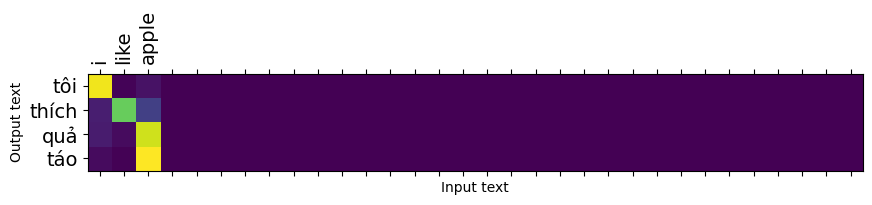

In [51]:
human_input = 'i like apple'
try: 
    alpha.plot_attention(human_input)
except Exception as err:
    print(f"Unexpected {err=}, {type(err)=}")